# LangGraph

LangGraph is a framework that allows you to define execution flows. It is designed for building agentic systems.

In [2]:
from time import sleep
from typing import TypedDict
from langgraph.graph import END, START, StateGraph

## Parallel execution

If a node has multiple outgoing edges, the flows defined by those edges will execute in parallel.

---

The following cell defines and displays this type of graph. The nodes of the graph display information about the start and end of exection, and block the flow for a while.

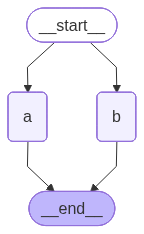

In [11]:
class State(TypedDict):
    pass

builder = StateGraph(State)

def node_a(state: State):
    print("executing a")
    sleep(10)
    print("finishing a")

def node_b(state: State):
    print("executing b")
    sleep(10)
    print("execution b")

builder.add_node("a", node_a)
builder.add_node("b", node_b)

builder.add_edge(START, "a")
builder.add_edge(START, "b")
graph = builder.compile()
graph

The project's invocation is represented in the following cell:

In [12]:
graph.invoke(State())

executing a
executing b
finishing a
execution b


It follows from the result that flows was executed in parallel.

## Merging output

If two graph flows join at the same node and both return a value, there will be a conflict. You must specify a strategy for merging the outputs using a **reducer function**.

THe **reducer function** can be defined as metatdata of the `typing.Annotated` for the specific attribute. This function will be applied if the outputs from those nodes need to be processed in some way. The most common way is to use the `operator.add` function, which is equivalent to simply apply the `+` operator.

---

The following cell shows a regular graph with two flows join at the `END` node, and both return some information.

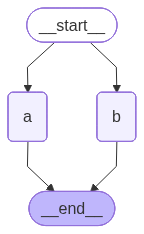

In [ ]:
class State(TypedDict):
    out: str

def node_a(state: State) -> State:
    return State(out="A output")

def node_b(state: State) -> State:
    return State(out="B output")

builder = StateGraph(State)

builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_edge(START, "a")
builder.add_edge(START, "b")

graph = builder.compile()
graph

Executing such a graph results in the error displayed in the following cell.

In [24]:
try:
    graph.invoke(State(out="start"))
except Exception as e:
    print(type(e).__name__, ":", e)

InvalidUpdateError : At key 'out': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_CONCURRENT_GRAPH_UPDATE


The following cell shows the definition of the state that applies `operator.add` when there are two outputs in a node.

In [5]:
import operator
from typing import Annotated

class State(TypedDict):
    out: Annotated[str, operator.add]

Here is an example of invoking the same graph with an updated state schema.

In [6]:
def node_a(state: State) -> State:
    return State(out="A output")

def node_b(state: State) -> State:
    return State(out="B output")

builder = StateGraph(State)

builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_edge(START, "a")
builder.add_edge(START, "b")

graph = builder.compile()
graph.invoke(State(out="value"))

{'out': 'valueA outputB output'}

As a result, the outputs of the different nodes were simply concatenated.